In [1]:
# Packages for Data Wrangling
import numpy as np
import pandas as pd
import os
import re
from collections import Counter

# For graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Use cleaner absolute path to find file
path = os.path.abspath('../politifact.csv')
df = pd.read_csv(path)

In [10]:
# Check for null values and total number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14209 entries, 0 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  14209 non-null  object
 1   source     14209 non-null  object
 2   link       14209 non-null  object
 3   veracity   14209 non-null  object
dtypes: object(4)
memory usage: 444.2+ KB


# Initially 16611 rows of non-null data

In [11]:
# to see statement in full
pd.set_option('display.max_colwidth', 200) 

# See sample of data
df.head(3)



,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180705082623/https://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
1,"Says Ronald Reagan said immigrants ""brought with them courage and the values of family, work, and freedom. Let us pledge to each other that we can make America great again.""",Becoming American Initiative,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/becoming-american-initiative/did-ronald-reagan-say-immigrants-made-america-grea/,Mostly True
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,/web/20180705082623/https://www.politifact.com/punditfact/statements/2018/jul/03/viral-image/viral-image-criticizing-democrats-featured-fabrica/,Pants on Fire!


In [12]:
# check groups that exist in veracity column
df.veracity.value_counts()

Half-True         2786
Mostly True       2695
False             2641
Mostly False      2335
True              2158
Pants on Fire!    1359
Full Flop          144
Half Flip           67
No Flip             24
Name: veracity, dtype: int64

In [13]:
# Full Flop, Half Flip, & No Flip have nothing to do with veracity; remove them
# Half-True, Mostly True, & Mostly False are non-exclusive groups; remove them
ver_df = df[df.isin(['True',
                    'False',
                    'Pants on Fire!']).any(axis=1)]

In [14]:
# The total number of rows should sum to 7431 (false(3274) + true(2340) + pants on fire(1817) = 7431)
ver_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6158 entries, 0 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  6158 non-null   object
 1   source     6158 non-null   object
 2   link       6158 non-null   object
 3   veracity   6158 non-null   object
dtypes: object(4)
memory usage: 240.5+ KB


# 7431 rows survived

In [15]:
# check if large imbalance in the 3 classes
ver_df.veracity.value_counts()

False             2641
True              2158
Pants on Fire!    1359
Name: veracity, dtype: int64

In [16]:
# randomly sample 10 rows
ver_df.iloc[0:100:10]

,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180705082623/https://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
12,"Says Wisconsin ""hadn’t been won by a Republican since Dwight D. Eisenhower, in 1952. And I won Wisconsin. … Ronald Reagan, remember, Wisconsin was the state that Ronald Reagan did not win.""",Donald Trump,/web/20180705082623/https://www.politifact.com/wisconsin/statements/2018/jun/29/donald-trump/president-trump-makes-some-interesting-claims-abou/,Pants on Fire!
29,"A Chinese proverb says, ""Those who say it can not be done, should not interrupt those doing it.""",Ivanka Trump,/web/20180701030417/http://www.politifact.com/truth-o-meter/statements/2018/jun/22/ivanka-trump/no-evidence-link-ivanka-trump-quote-chinese-prover/,False
47,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180717183606/http://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!
58,"Says Ron DeSantis ""voted in an agricultural bill to give food stamps to illegal immigrants.""",Adam Putnam,/web/20180717183606/http://www.politifact.com/florida/statements/2018/jun/29/adam-putnam/putnam-parrots-previous-absurd-claim-food-stamps-i/,Pants on Fire!
72,"""Breaking: woman says she was offered big money by Washington Post to accuse Roy Moore of misconduct.""",Evening World,/web/20180106054644/http://www.politifact.com/punditfact/statements/2017/dec/11/evening-world/fake-news-about-washington-post-and-roy-moore-accu/,Pants on Fire!
95,"""Crime in Germany is way up.""",Donald Trump,/web/20180715231626/http://www.politifact.com/truth-o-meter/statements/2018/jun/18/donald-trump/donald-trump-wrong-about-crime-germany/,False
127,"""Hillary Clinton lied many times to the FBI.""",Donald Trump,/web/20180119081744/http://www.politifact.com/truth-o-meter/statements/2017/dec/05/donald-trump/donald-trump-falsely-claims-hillary-clinton-lied-f/,False
142,"Says Joe Scarborough is party to an ""unsolved mystery"" from his time as a congressman in Florida.",Donald Trump,/web/20180119142313/http://www.politifact.com/truth-o-meter/statements/2017/nov/29/donald-trump/donald-trumps-pants-fire-unsolved-mystery-attack-j/,Pants on Fire!
164,"""The elimination of income and sales taxes in New York is equal to 9 percent of taxable income, meaning that if you make $100,000 a year you lose $9,000""",Brian Higgins,/web/20180119155920/http://www.politifact.com/new-york/statements/2017/nov/20/brian-higgins/not-all-state-and-local-tax-deductions-eliminated-/,False


# Should remove statements that begin with "Says entity said" as there are 2 reasons this may be false: speaker is false or statement is false.

# Filter for sentences that begin with a quotation

In [17]:
ver_df[ver_df.statement.str.match(r"\"")==True][0:100:10]

,statement,source,link,veracity
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!
21,"""NASA announced that it communicated with four races of aliens.""",Bloggers,/web/20180701030417/http://www.politifact.com/punditfact/statements/2018/jun/25/blog-posting/no-nasa-has-not-communicated-aliens/,Pants on Fire!
49,"""George H.W. Bush has died at 94.""",Bloggers,/web/20180717183606/http://www.politifact.com/punditfact/statements/2018/jul/02/blog-posting/hoax-website-says-george-h-w-bush-died-he-didnt/,Pants on Fire!
68,"""Facebook picks sides in Alabama Senate race ... shuts down Gateway Pundit and Breitbart reports on discredited Allred accuser""",The Gateway Pundit,/web/20180106054644/http://www.politifact.com/punditfact/statements/2017/dec/11/gateway-pundit/facebook-did-not-remove-gateway-pundit-report-afte/,False
95,"""Crime in Germany is way up.""",Donald Trump,/web/20180715231626/http://www.politifact.com/truth-o-meter/statements/2018/jun/18/donald-trump/donald-trump-wrong-about-crime-germany/,False
135,"""For years, they have not been able to get tax cuts -- many, many years, since Reagan.""",Donald Trump,/web/20180119081744/http://www.politifact.com/truth-o-meter/statements/2017/nov/30/donald-trump/donald-trump-wrong-no-tax-cuts-passed-reagan/,Pants on Fire!
159,"""Civil war erupts in Sweden as irate Swedes burn nine Muslim refugee centers to the ground""",Pipo News,/web/20180119142313/http://www.politifact.com/punditfact/statements/2017/nov/21/pipo-news/fake-news-civil-war-erupts-sweden/,False
203,"""Supreme Court issues its first bench warrant ever.""",FreedomJunkshun.com,/web/20180119163549/http://www.politifact.com/punditfact/statements/2017/nov/09/freedomjunkshuncom/fake-news-story-says-supreme-court-issues-bogus-wa/,Pants on Fire!
243,"""Breitbart leaks names of four Dems being charged in Mueller’s Russia probe.""",FreedomJunkshun.com,/web/20180119164739/http://www.politifact.com/punditfact/statements/2017/oct/31/freedomjunkshuncom/fake-news-post-says-breitbart-named-4-democrats-in/,Pants on Fire!
295,"""Our tax code has nearly doubled since 1985.""",Roy Blunt,/web/20180119165429/http://www.politifact.com/missouri/statements/2017/oct/17/roy-blunt/tax-code-so-long-nobodys-really-sure-its-length/,True


# Precision: 100% 
## true positive / (true positive + false positive)

In [18]:
ver_df[ver_df.statement.str.match(r"\"")==False][0:100:10]

,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180705082623/https://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
46,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,/web/20180717183606/http://www.politifact.com/punditfact/statements/2018/jul/03/viral-image/viral-image-criticizing-democrats-featured-fabrica/,Pants on Fire!
99,"Says ""massive floods"" led to Legionnaires’ disease outbreaks at the Quincy Veterans’ Home.",Bruce Rauner,/web/20180715231626/http://www.politifact.com/illinois/statements/2018/jun/18/bruce-rauner/rauners-legionnaires-claim-misses-mark-and-point/,False
176,Bowe Bergdahl wanders off during court-martial,Duffel Blog,/web/20180119155920/http://www.politifact.com/punditfact/statements/2017/nov/16/duffel-blog/no-bowe-bergdahl-didnt-wander-during-court/,Pants on Fire!
204,"Says Roy Moore said a ""practicing Muslim should not be a member of Congress because of his faith.""",Jeff Flake,/web/20180119163549/http://www.politifact.com/truth-o-meter/statements/2017/nov/09/jeff-flake/flake-roy-moore-said-muslims-shouldnt-serve-congre/,True
253,"What Republicans call the ""death tax"" is the estate tax ""on the ultra wealthy"" which, in 2016, was paid by only ""two out of every 1,000 people.""",Mark Pocan,/web/20180119164739/http://www.politifact.com/wisconsin/statements/2017/oct/27/mark-pocan/death-tax-republicans-want-repeal-paid-only-2-1000/,True
304,"A Homeland Security study ""showed 120 murders took place that could have been prevented had communities been working with ICE and Homeland Security.""",Casey Cagle,/web/20180119165719/http://www.politifact.com/georgia/statements/2017/oct/12/casey-cagle/georgia-lt-gov-casey-cagle-misleads-claim-about-ho/,False
342,Said there is cholera in Puerto Rico after Hurricane Maria.,Paul Krugman,/web/20180119170045/http://www.politifact.com/punditfact/statements/2017/oct/02/paul-krugman/paul-krugmans-wrongly-tweets-about-cholera-puerto-/,False
388,"Vermont had to ""scrap"" its single-payer health insurance program because it was ""going bankrupt.""",Sean Duffy,/web/20180119170540/http://www.politifact.com/wisconsin/statements/2017/sep/20/sean-duffy/vermont-single-payer-was-scrapped-because-it-was-g/,False
454,Photo shows severe flooding at a Houston airport.,Bloggers,/web/20180119170819/http://www.politifact.com/punditfact/statements/2017/aug/29/blog-posting/fake-photo-shows-possible-climate-change-effects-n/,Pants on Fire!


# Negative Predictive Value: 100% 
## true negative / (true negative + false negative)

In [19]:
# Let's see how much data remains with this filtering method, i.e., how many are True
Counter(ver_df.statement.str.match(r"\""))

Counter({False: 3298, True: 2860})

In [20]:
# verify above results using a different method
Counter(ver_df.statement.str.startswith('"'))

Counter({False: 3298, True: 2860})

# 3415 rows survive

# Do other filters give better survival rates?

# Filter: contains second-hand statement

In [21]:
ver_df[ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said")==True][0:100:10]

,statement,source,link,veracity
2,"Says Democratic Senators ""demand Supreme Court nominee not be unduly influenced by U.S. Constitution.""",Viral image,/web/20180705082623/https://www.politifact.com/punditfact/statements/2018/jul/03/viral-image/viral-image-criticizing-democrats-featured-fabrica/,Pants on Fire!
56,"Says Wisconsin ""hadn’t been won by a Republican since Dwight D. Eisenhower, in 1952. And I won Wisconsin. … Ronald Reagan, remember, Wisconsin was the state that Ronald Reagan did not win.""",Donald Trump,/web/20180717183606/http://www.politifact.com/wisconsin/statements/2018/jun/29/donald-trump/president-trump-makes-some-interesting-claims-abou/,Pants on Fire!
134,"Says the tax bill ""is going to cost me a fortune, this thing -- believe me. Believe me, this is not good for me.""",Donald Trump,/web/20180119081744/http://www.politifact.com/truth-o-meter/statements/2017/nov/30/donald-trump/will-gop-tax-bill-cost-donald-trump-fortune-no/,False
230,"Says Jake Tapper said Allahu Akbar was a ""beautiful phrase"" after a terrorist attack in New York.",Sebastian Gorka,/web/20180119164415/http://www.politifact.com/punditfact/statements/2017/nov/02/sebastian-gorka/seb-gorka-misquotes-jake-tappers-comment-about-all/,Pants on Fire!
335,"Says ""the Kardashians donate whopping sum to Las Vegas mass shooting victims""",HoustonChronicle-tv.com,/web/20180119165835/http://www.politifact.com/punditfact/statements/2017/oct/03/houstonchronicle-tvcom/its-fake-news-kardashians-donated-1-million-las-ve/,Pants on Fire!
446,"Says video shows Mike Pence quoting the Bible as justification for ""Congress not to fund Katrina relief effort.""",Liberal Bloggers,/web/20180119170819/http://www.politifact.com/truth-o-meter/statements/2017/aug/31/liberal-bloggers/mike-pence-cited-bible-oppose-katrina-relief-liber/,Pants on Fire!
525,"Says Russian President Vladimir Putin said Pope Francis ""is not a man of God.""",Bloggers,/web/20180119170930/http://www.politifact.com/punditfact/statements/2017/aug/08/blog-posting/vladimir-putin-said-pope-francis-not-man-god-blogg/,Pants on Fire!
584,Says President Richard Nixon held meetings with heads of state without an American interpreter.,Ian Bremmer,/web/20180119171018/http://www.politifact.com/punditfact/statements/2017/jul/21/ian-bremmer/nixon-sometimes-met-leaders-without-his-own-transl/,True
628,"Says ""James Comey Has Been Having An Affair With"" Debbie Wasserman Schultz.",FreedomCrossroads.us,/web/20180119171045/http://www.politifact.com/punditfact/statements/2017/jul/10/freedomcrossroadsus/its-fake-news-james-comey-and-debbie-wasserman-sch/,Pants on Fire!
709,"Says the Senate Intelligence Committee has held 10 public hearings this year, ""more than double that held by the committee in any recent year.""",Richard Burr,/web/20180119171134/http://www.politifact.com/north-carolina/statements/2017/jun/14/richard-burr/russia-investigation-senate-hearings-have-uncommon/,True


# Precision: 100%

In [22]:
ver_df[ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said")==False][0:100:10]

,statement,source,link,veracity
0,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180705082623/https://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
20,"""Burka clad woman runs over baby, gets away with crime for one stunning reason ...""",Bloggers,/web/20180701030417/http://www.politifact.com/ohio/statements/2018/jun/26/blog-posting/blog-site-wrongly-claims-muslim-woman-escaped-puni/,False
44,"Sen. Kamala Harris is ""supporting the animals of MS-13.""",Donald Trump,/web/20180717183606/http://www.politifact.com/california/statements/2018/jul/03/donald-trump/pants-fire-white-house-claim-sen-harris-supporting/,Pants on Fire!
64,"""Under Trump’s new tax plan … 99.8% of Americans"" get ""not one nickel"" in tax cuts.",Kelda Helen Roys,/web/20180106054644/http://www.politifact.com/wisconsin/statements/2017/dec/13/kelda-helen-roys/claim-998-americans-wouldnt-get-tax-cut-under-gop-/,Pants on Fire!
80,"""Bill Clinton passed a law in 1996 that separated children from adults illegally entering America.""",Bloggers,/web/20180715231626/http://www.politifact.com/punditfact/statements/2018/jun/21/blog-posting/no-bill-clinton-law-separating-families/,False
125,"""Breaking: federal judge grants permission to subpoena Trump.""",news.groopspeak.com,/web/20180119081744/http://www.politifact.com/punditfact/statements/2017/dec/05/newsgroopspeakcom/no-judge-grant-subpoena-president-donald-trump/,False
148,"""President Trump just saved Christmas for 13 million retirees.""",Reaganwasright,/web/20180119142313/http://www.politifact.com/punditfact/statements/2017/nov/27/reaganwasright/fake-news-says-trump-sending-stimulus-money-retire/,Pants on Fire!
174,"Iran’s regime ""every Friday declares war on us.""",Sebastian Gorka,/web/20180119155920/http://www.politifact.com/north-carolina/statements/2017/nov/16/sebastian-gorka/fact-check-former-white-house-aide-says-iran-every/,False
195,"""Many firearms experts determined the Las Vegas shooter’s use of a bump stock actually prevented more casualties and (injuries) due to its inconsistency, inaccuracy, and lack of control.""",Michael Williams,/web/20180119162004/http://www.politifact.com/georgia/statements/2017/nov/13/michael-williams/did-bump-stocks-prevent-more-casualties-las-vegas/,False
229,"""We’re growing union jobs faster than Illinois.""",Eric Holcomb,/web/20180119164415/http://www.politifact.com/illinois/statements/2017/nov/03/eric-holcomb/indiana-governor-right-gloat-about-union-jobs-succ/,True


# Negative Predictive Value: 100%

In [23]:
Counter(ver_df.statement.str.contains(r"Says|Quotes|Say|Said|say|saying|said"))

Counter({False: 4501, True: 1657})

# 5266 rows survive

# While more rows survive, the quality of the suriving rows is questionable. For example, 

## Del. Debra Rodman "opposes adoption as an alternative to abortion in event of unplanned pregnancies."

# Liars may use distancing language such as "she" and since the above quote was edited to indicate the subject, Del. Debra Rodman, the quality of this falsehood diminishes. This can also be said of 104, 148, etc.

# We'll use a begins-with-and-ends-with-quotations filter going forward

In [24]:
quote_df = ver_df[ver_df.statement.str.match(r'\"')==True]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2860 entries, 3 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2860 non-null   object
 1   source     2860 non-null   object
 2   link       2860 non-null   object
 3   veracity   2860 non-null   object
dtypes: object(4)
memory usage: 111.7+ KB


In [25]:
# remove sentences that don't end with a quotation
quote_df = quote_df[quote_df.statement.str.endswith('"')==True]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2647 entries, 3 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2647 non-null   object
 1   source     2647 non-null   object
 2   link       2647 non-null   object
 3   veracity   2647 non-null   object
dtypes: object(4)
memory usage: 103.4+ KB


In [26]:
# remove sentences that are several quotes strung together
quote_df = quote_df[quote_df.statement.str.contains(r'\"{1}.+\"{1}.+\"{1}')==False]
quote_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2574 entries, 3 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  2574 non-null   object
 1   source     2574 non-null   object
 2   link       2574 non-null   object
 3   veracity   2574 non-null   object
dtypes: object(4)
memory usage: 100.5+ KB


In [27]:
quote_df.veracity.value_counts()

True              1033
False             1011
Pants on Fire!     530
Name: veracity, dtype: int64

In [28]:
# how many unique sources?
quote_df.describe(include='all')

,statement,source,link,veracity
count,2574,2574,2574,2574
unique,2562,1096,2574,3
top,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Donald Trump,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,True
freq,2,115,1,1033


In [29]:
# top 10 sources
quote_df.source.value_counts()[:10]

Donald Trump       115
Bloggers           106
Barack Obama       101
Hillary Clinton     58
John McCain         49
Mitt Romney         42
Chain email         40
Rick Perry          28
Scott Walker        27
John Boehner        26
Name: source, dtype: int64

# There is an imbalance in the sources (some appear far too often)

# By examining the source frequency's mean and median, we can determine how many times most sources are quoted to figure out a way to balance the data

In [30]:
quote_df.source.value_counts().mean()

2.3485401459854014

In [31]:
quote_df.source.value_counts().median()

1.0

In [32]:
sum(quote_df.source.value_counts() <= 3)

991

In [33]:
quote_df['freq'] = quote_df.groupby('source')['source'].transform('count')

In [34]:
quote_df[quote_df.freq <= 3].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1252 entries, 3 to 14208
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  1252 non-null   object
 1   source     1252 non-null   object
 2   link       1252 non-null   object
 3   veracity   1252 non-null   object
 4   freq       1252 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 58.7+ KB


# New dataframe will only tolerate a single source appearing 3 times

In [35]:
balanced_df = quote_df[quote_df.freq <= 3]

In [36]:
# how many unique sources?
balanced_df.describe(include='all')

,statement,source,link,veracity,freq
count,1252,1252,1252,1252,1252.000000
unique,1247,991,1252,3,NaN
top,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Sam Brownback,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,True,NaN
freq,2,3,1,518,NaN
mean,NaN,NaN,NaN,NaN,1.492013
std,NaN,NaN,NaN,NaN,0.689605
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,2.000000


In [37]:
balanced_df.veracity.value_counts()

True              518
False             489
Pants on Fire!    245
Name: veracity, dtype: int64

In [38]:
# top 10 sources
balanced_df.source.value_counts()[:10]

Sam Brownback      3
Johnny Isakson     3
Bob McDonnell      3
Bill Nelson        3
Harry Reid         3
Marcia Fudge       3
Lincoln Chafee     3
Lamar Alexander    3
Connie Mack        3
Betty Sutton       3
Name: source, dtype: int64

# 1455 balanced rows survived

In [39]:
balanced_df[:100:10]

,statement,source,link,veracity,freq
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!,2
68,"""Facebook picks sides in Alabama Senate race ... shuts down Gateway Pundit and Breitbart reports on discredited Allred accuser""",The Gateway Pundit,/web/20180106054644/http://www.politifact.com/punditfact/statements/2017/dec/11/gateway-pundit/facebook-did-not-remove-gateway-pundit-report-afte/,False,2
126,"""Tennessee GOP twitter taken down after tweet exposing Pelosi involved in pedophilia.""",PuppetStringNews.com,/web/20180119081744/http://www.politifact.com/punditfact/statements/2017/dec/05/puppetstringnewscom/fake-russian-twitter-account-center-fake-tweet-abo/,Pants on Fire!,3
164,"""The elimination of income and sales taxes in New York is equal to 9 percent of taxable income, meaning that if you make $100,000 a year you lose $9,000""",Brian Higgins,/web/20180119155920/http://www.politifact.com/new-york/statements/2017/nov/20/brian-higgins/not-all-state-and-local-tax-deductions-eliminated-/,False,1
236,"""Alabama’s Crimson Tide was disqualified from national championship.""",BreakingNews247.net,/web/20180119164415/http://www.politifact.com/punditfact/statements/2017/nov/01/breakingnews247net/fake-news-generator-claims-alabama-football-disqua/,Pants on Fire!,1
309,"""Under his leadership, Tallahassee reduced its carbon intensity by roughly 40 percent.""",Andrew Gillum,/web/20180119165719/http://www.politifact.com/florida/statements/2017/oct/12/andrew-gillum/gillum-campaign-changes-website-after-touting-fals/,False,1
417,"""The Affordable Care Act is the single largest tax increase in my lifetime.""",Karen Handel,/web/20180119170716/http://www.politifact.com/georgia/statements/2017/sep/11/karen-handel/handel-wrong-size-obamacare-taxes/,False,3
493,"""There are communities under Sharia law right now in our country. Up in Illinois. ... There’s Sharia law, as I understand it, in Illinois, Indiana -- up there. I don't know.""",Roy Moore,/web/20180119170854/http://www.politifact.com/truth-o-meter/statements/2017/aug/16/roy-moore/alabamas-roy-moore-says-whole-communities-midwest-/,Pants on Fire!,1
591,"""The last majority-Anglo high school class in Texas graduated in 2014.""",Evan Smith,/web/20180119171018/http://www.politifact.com/texas/statements/2017/jul/19/evan-smith/evan-smith-incorrectly-says-last-anglo-majority-te/,False,1
685,"""A study by the National Economics Research Association showed that the (Paris climate) deal could cost 2.7 million lost jobs in the U.S. by 2025 should our country adhere to the commitments made ...",Gus Bilirakis,/web/20180119171122/http://www.politifact.com/florida/statements/2017/jun/21/gus-bilirakis/gus-bilirakis-cites-flawed-study-defend-us-wit/,False,1


# Verify the dates of the data

In [56]:

# r() = first group to extract; you can use multiple ()
# ?P<column_name> = column name for convenience
# \d = digit
# {n} = number of digits to include
# . = wildcard
# + = greedy search
# ? = but not too greedy
# extracting the date from the link column
balanced_df["date"] = balanced_df.link.str.extract(r'(\d{4}/.+?\d{2})')

/var/folders/vt/sb7354610c9c85znvk8qs0340000gq/T/ipykernel_30167/2398731616.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balanced_df["date"] = balanced_df.link.str.extract(r'(\d{4}/.+?\d{2})')


In [57]:
balanced_df.head(3)

,statement,source,link,veracity,freq,date
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!,2,2623/https://www.politifact.com/truth-o-meter/statements/20
6,"""The deficit ... is coming down, and it’s coming down rapidly.""",Larry Kudlow,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/02/larry-kudlow/larry-kudlow-wrong-about-deficits-falling-rapidly-/,Pants on Fire!,2,2623/https://www.politifact.com/truth-o-meter/statements/20
10,"""Our courts find that 80 percent of those who do file for asylum aren’t qualified for it, do not merit that relief.""",Jeff Sessions,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/02/jeff-sessions/jeff-sesssions-false-claim-80-percent-asylum-appli/,False,3,2623/https://www.politifact.com/truth-o-meter/statements/20


In [42]:
# change the date column to a datetime column for convenience
balanced_df.date = pd.to_datetime(balanced_df.date,infer_datetime_format=True)

ParserError: Unknown string format: 2623/https://www.politifact.com/truth-o-meter/statements/20 present at position 0

In [43]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1252 entries, 3 to 14208
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  1252 non-null   object
 1   source     1252 non-null   object
 2   link       1252 non-null   object
 3   veracity   1252 non-null   object
 4   freq       1252 non-null   int64 
 5   date       1252 non-null   object
dtypes: int64(1), object(5)
memory usage: 68.5+ KB


In [44]:
balanced_df[:90:30]

,statement,source,link,veracity,freq,date
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!,2,2623/https://www.politifact.com/truth-o-meter/statements/20
164,"""The elimination of income and sales taxes in New York is equal to 9 percent of taxable income, meaning that if you make $100,000 a year you lose $9,000""",Brian Higgins,/web/20180119155920/http://www.politifact.com/new-york/statements/2017/nov/20/brian-higgins/not-all-state-and-local-tax-deductions-eliminated-/,False,1,5920/http://www.politifact.com/new-york/statements/20
417,"""The Affordable Care Act is the single largest tax increase in my lifetime.""",Karen Handel,/web/20180119170716/http://www.politifact.com/georgia/statements/2017/sep/11/karen-handel/handel-wrong-size-obamacare-taxes/,False,3,0716/http://www.politifact.com/georgia/statements/20


In [45]:
balanced_df.head(2)

,statement,source,link,veracity,freq,date
3,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Corey Stewart,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/03/corey-stewart/corey-stewart-falsely-claims-sen-tim-kaine-wants-d/,Pants on Fire!,2,2623/https://www.politifact.com/truth-o-meter/statements/20
6,"""The deficit ... is coming down, and it’s coming down rapidly.""",Larry Kudlow,/web/20180705082623/https://www.politifact.com/truth-o-meter/statements/2018/jul/02/larry-kudlow/larry-kudlow-wrong-about-deficits-falling-rapidly-/,Pants on Fire!,2,2623/https://www.politifact.com/truth-o-meter/statements/20


In [46]:
#by year
ax = balanced_df.groupby(balanced_df.date.dt.year).count().plot(kind="bar")
ax.legend_ = None
plt.title("Distribution by Year")
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

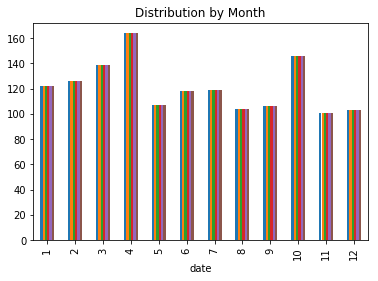

In [40]:
#by month
ax = balanced_df.groupby(balanced_df.date.dt.month).count().plot(kind="bar")
ax.legend_ = None
plt.title("Distribution by Month")
plt.show()

# The quality and balance of the data has improved

In [47]:
cleaned_df = balanced_df[["date","source","freq","statement","veracity"]]

In [58]:
cleaned_df[:100:10]

,date,source,freq,statement,veracity,length
3,2623/https://www.politifact.com/truth-o-meter/statements/20,Corey Stewart,2,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Pants on Fire!,141
68,4644/http://www.politifact.com/punditfact/statements/20,The Gateway Pundit,2,"""Facebook picks sides in Alabama Senate race ... shuts down Gateway Pundit and Breitbart reports on discredited Allred accuser""",False,127
126,1744/http://www.politifact.com/punditfact/statements/20,PuppetStringNews.com,3,"""Tennessee GOP twitter taken down after tweet exposing Pelosi involved in pedophilia.""",Pants on Fire!,86
164,5920/http://www.politifact.com/new-york/statements/20,Brian Higgins,1,"""The elimination of income and sales taxes in New York is equal to 9 percent of taxable income, meaning that if you make $100,000 a year you lose $9,000""",False,153
236,4415/http://www.politifact.com/punditfact/statements/20,BreakingNews247.net,1,"""Alabama’s Crimson Tide was disqualified from national championship.""",Pants on Fire!,69
309,5719/http://www.politifact.com/florida/statements/20,Andrew Gillum,1,"""Under his leadership, Tallahassee reduced its carbon intensity by roughly 40 percent.""",False,87
417,0716/http://www.politifact.com/georgia/statements/20,Karen Handel,3,"""The Affordable Care Act is the single largest tax increase in my lifetime.""",False,76
493,0854/http://www.politifact.com/truth-o-meter/statements/20,Roy Moore,1,"""There are communities under Sharia law right now in our country. Up in Illinois. ... There’s Sharia law, as I understand it, in Illinois, Indiana -- up there. I don't know.""",Pants on Fire!,174
591,1018/http://www.politifact.com/texas/statements/20,Evan Smith,1,"""The last majority-Anglo high school class in Texas graduated in 2014.""",False,71
685,1122/http://www.politifact.com/florida/statements/20,Gus Bilirakis,1,"""A study by the National Economics Research Association showed that the (Paris climate) deal could cost 2.7 million lost jobs in the U.S. by 2025 should our country adhere to the commitments made ...",False,225


In [59]:
cleaned_df["length"] = cleaned_df.statement.str.len()

In [50]:
cleaned_df.describe()

,freq,length
count,1252.000000,1252.000000
mean,1.492013,104.703674
std,0.689605,44.048399
min,1.000000,17.000000
25%,1.000000,73.000000
50%,1.000000,96.000000
75%,2.000000,130.000000
max,3.000000,295.000000


In [60]:
cleaned_df[cleaned_df.length > 250][:100]

,date,source,freq,statement,veracity,length
250,4739/http://www.politifact.com/california/statements/20,Delaine Eastin,1,"""Ninety percent of people born in the 1940s ended up doing better financially than their parents. But those born in the 1980s, the much-maligned Millennials, have only a 50-50 chance of doing bett...",True,292
400,0716/http://www.politifact.com/truth-o-meter/statements/20,Kris Kobach,1,"""Facts have come to light that indicate that a pivotal, close election was likely changed through voter fraud on November 8, 2016: New Hampshire’s U.S. Senate Seat, and perhaps also New Hampshire’...",False,257
1068,1426/http://www.politifact.com/truth-o-meter/statements/20,Tom Price,1,"""The number of individuals who actually got coverage through the exchange who didn't have coverage before, or who weren't eligible for Medicaid before is relatively small. So we've turned things u...",False,273
1676,1703/http://www.politifact.com/california/statements/20,Loretta Sanchez,2,"""If you give guns to gangs, you can get out of jail free, if (California’s Proposition 57) passes. If you do a drive-by shooting, you can get out of jail free, if Proposition 57 passes. If you dis...",False,256
2034,1804/http://www.politifact.com/illinois/statements/20,Richard Durbin,3,"""Illinois suffered 1,652 overdose deaths in 2014 ... of which 40 percent were associated with heroin. Illinois is ranked number one in the nation for a decline in treatment capacity between 2007 a...",True,291
4723,2403/http://www.politifact.com/rhode-island/statements/20,"Vincent ""Buddy"" Cianci",2,"""[When I was mayor] Providence was one of the five renaissance cities of America, according to USA Today in those days. Money magazine said it was the fifth best city to live in in America. In add...",True,295
5930,2713/http://www.politifact.com/new-jersey/statements/20,Joseph Cryan,1,"""What do Rutgers University, Kean University, Montclair State University, New Jersey City University, Stockton College, Rowan University and William Paterson all have in common? They all graduate ...",True,254
13678,0457/http://www.politifact.com/truth-o-meter/statements/20,Bob Barr,1,"""The legislation ... that Senator McCain supports would provide the authority for the federal government to surveille American citizens in their own country without any suspicion whatsoever that t...",True,271


In [61]:
cleaned_df[cleaned_df.statement.str.match(r"\"Palin")==True]

,date,source,freq,statement,veracity,length
13474,0422/http://www.politifact.com/truth-o-meter/statements/20,Defenders of Wildlife Action Fund,1,"""Palin (proposed) a $150 bounty for the severed foreleg of each killed wolf.""",True,77


In [62]:
cleaned_df.head(2)

,date,source,freq,statement,veracity,length
3,2623/https://www.politifact.com/truth-o-meter/statements/20,Corey Stewart,2,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Pants on Fire!,141
6,2623/https://www.politifact.com/truth-o-meter/statements/20,Larry Kudlow,2,"""The deficit ... is coming down, and it’s coming down rapidly.""",Pants on Fire!,63


In [63]:
#Drop the date column
cleaned_df = cleaned_df.drop("date",axis=1)

In [64]:
cleaned_df.head(2)

,source,freq,statement,veracity,length
3,Corey Stewart,2,"""Tim Kaine doesn’t want a border at all. He wants to get rid of Immigration and Customs Enforcement and basically the border patrol as well.""",Pants on Fire!,141
6,Larry Kudlow,2,"""The deficit ... is coming down, and it’s coming down rapidly.""",Pants on Fire!,63


In [65]:
cleaned_df.to_csv('politifact_cleaned_data.csv')

In [54]:
trump_df = quote_df[quote_df.source == "Donald Trump"]
trump_df.head(2)

,statement,source,link,veracity,freq
35,"""The Kurds are much safer right now.""",Donald Trump,/truth-o-meter/statements/2019/oct/16/donald-trump/after-attacks-turkey-trump-falsely-claims-kurds-sy/,False,181
58,"""Fact: Joe Biden pressured Ukraine to fire its prosecutor .... Fact: the prosecutor said he was forced out for leading a corruption probe into Hunter Biden's company. Fact: Democrats want to impea...",Donald Trump,/truth-o-meter/statements/2019/oct/11/donald-trump/trump-ad-misleads-about-biden-ukraine-and-prosecut/,False,181


In [55]:
obama_df = quote_df[quote_df.source == "Barack Obama"]
obama_df.head(2)

,statement,source,link,veracity,freq
4075,"""Refugees are subject to more rigorous screening than the average tourist in the U.S.""",Barack Obama,/global-news/statements/2016/oct/13/barack-obama/refugee-summit-obama-claims-refugees-us-are-screen/,True,101
4672,"""The steel industry is producing as much steel in the United States as it ever was. It’s just (that) it needs one-tenth of the workers that it used to.""",Barack Obama,/truth-o-meter/statements/2016/jul/05/barack-obama/barack-obama-wrong-about-size-us-steel-production-/,False,101


In [56]:
trump_df.to_csv('politifact_trump_data.csv')
obama_df.to_csv('politifact_obama_data.csv')